# Ensemble Learning Exercise

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import collections
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y = True);
data = load_boston();
df = pd.DataFrame(data.data, columns = data.feature_names);
df.head()

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

* Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

* The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [6]:
class Tree():
    def __init__(self, dt, X, y, oob):
        self.dt = dt
        self.X = X
        self.y = y
        self.oob = oob
        self.columns = X.columns

class TreeEnsemble():
    def __init__(self, n_trees, sample_sz, n_features, min_leaf):
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        self.n_features = n_features
        self.min_leaf = min_leaf

    def fit(self, X, y):
        self.X = X
        self.y = y

        self.df = pd.DataFrame(np.append(X, y.reshape(-1,1), axis =1)) #restore X and y to one data frame, to make sampling and oob easier
        self.estimators = []

        for i in range(self.n_trees):
        #Random sampling, with replacement, of the data.
            x = self.df.iloc[:, :-1]
            y = self.df.iloc[:, -1]
            x_n_features = x.sample(self.n_features, axis = 1) #Take sample of the features, from our df_n_samples
            
            df_n_features = x_n_features.join(y)
            df_n_samps = df_n_features.sample(self.sample_sz, replace= True)

            samp_x = df_n_samps.iloc[:, :-1]
            samp_y = df_n_samps.iloc[:, -1]
        # #Random sampling of the features
        #     samp_x = samp_x.sample(self.n_features, axis = 1) #Take sample of the features, from our df_n_samples

            oob = df_n_features.drop(samp_x.index) # oob is all of the samples that weren't used, per tree.
           
        #Create tree (with min_leaf)
            dt = DecisionTreeRegressor(min_samples_leaf= self.min_leaf).fit(samp_x, samp_y)

            tree = Tree(dt = dt, X = samp_x, y = samp_y, oob = oob)
            
        #add tree to the total amount of classifiers.
            self.estimators.append(tree)


    def predict(self, X):
        
        predictions = []
        for tree in self.estimators:
            x = X[:, tree.columns]
            
            predictions.append(tree.dt.predict(x))
        
        return np.mean(predictions, axis = 0)

    def oob_mse(self):
        dict = collections.defaultdict(list)
        for tree in self.estimators:
            oob_x = tree.oob.iloc[:, :-1] #Just take the X of the oob; don't need the current y's.
            # oob_y = self.oob.iloc[:, -1]

            oob_pred = tree.dt.predict(oob_x)
            # mse = mean_squared_error(oob_y, oob_pred)

            for i, idx in enumerate(oob_x.index):
                dict[idx].append(oob_pred[i])

        mean_oob_predictions = []
        for x in dict.values():
            mean_oob_predictions.append(np.mean(x))

        oob_y = self.df.iloc[list(dict.keys()), -1] #return y, in order of the keys (indexes) of our oob dictionary
        self.oob_mse = mean_squared_error(oob_y, mean_oob_predictions)
        
        return self.oob_mse



In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

rf = RandomForestRegressor(n_estimators= 200, max_samples = 200, max_features = 5, min_samples_leaf= 1)
rf.fit(x_train, y_train)
mean_squared_error(y_test, rf.predict(x_test))

6.624627502450979

In [7]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

rf = TreeEnsemble(200, 200, 5, 1)
rf.fit(x_train,y_train)

In [8]:
mean_squared_error(y_test, rf.predict(x_test))

10.456744658261858

In [6]:
rf.oob_mse()

16.402043990659575

In [7]:
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(n, sz, 12, min_leaf)
      forest.fit(x_train, y_train)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
  


n_trees:1, sz:50, min_leaf:1 --- oob mse: 39.008767507002794
n_trees:1, sz:50, min_leaf:5 --- oob mse: 40.25454730755535
n_trees:1, sz:100, min_leaf:1 --- oob mse: 46.787981072555205
n_trees:1, sz:100, min_leaf:5 --- oob mse: 38.141801551023605
n_trees:1, sz:300, min_leaf:1 --- oob mse: 20.20683937823834
n_trees:1, sz:300, min_leaf:5 --- oob mse: 19.850300529376938
n_trees:1, sz:500, min_leaf:1 --- oob mse: 17.079344262295084
n_trees:1, sz:500, min_leaf:5 --- oob mse: 18.865287565580992
n_trees:5, sz:50, min_leaf:1 --- oob mse: 24.82539404466501
n_trees:5, sz:50, min_leaf:5 --- oob mse: 22.562328756481122
n_trees:5, sz:100, min_leaf:1 --- oob mse: 20.912582473872387
n_trees:5, sz:100, min_leaf:5 --- oob mse: 22.239001167511514
n_trees:5, sz:300, min_leaf:1 --- oob mse: 17.42373942861255
n_trees:5, sz:300, min_leaf:5 --- oob mse: 22.75753992636585
n_trees:5, sz:500, min_leaf:1 --- oob mse: 21.288646941896022
n_trees:5, sz:500, min_leaf:5 --- oob mse: 23.732130769340554
n_trees:10, sz:50

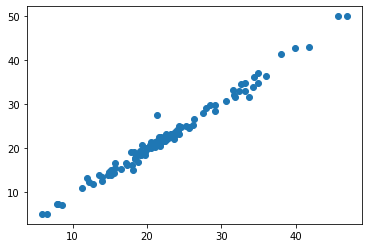

In [8]:
forest = TreeEnsemble(50, 500, 7, 1)
forest.fit(X, y)
y_hat = forest.predict(x_test)  # forest is the chosen model
plt.scatter(y_hat, y_test)

## 2. Implementing AdaBoost From Scratch (30 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?



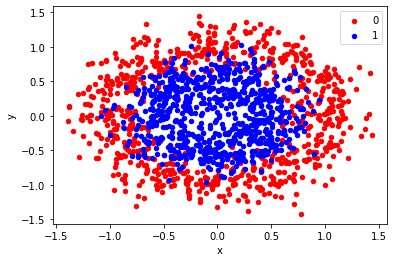

In [9]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [10]:
y[y==0] =-1

In [11]:
#Step 1: Intialize weights for each sample
#Step 2: For each classifier:
    #a) fit the classifier with the calculated weights of the previous classifier (either througha weighted gini index, or random weighted resampling).
        #Note: Make sure to resample each time from the original dataframe, but with the most recent weights.
    #b) Calculate the error
    #c) compute the significance of the classifier to the final prediction.
    #d) Create new, normalized weights
    #d) update the weights
#Step 3: Predict-- weighted majority vote of the models

In [12]:
class CustomAdaBoost():
    def __init__(self, classifier, n_classifiers, params = None):
        self.classifier = classifier
        self.all_classifiers = []
        self.n_classifiers = n_classifiers
        self.alphas = []
        self.weights = None
        self.params = params
    
    

    def fit(self, X, Y):
        
        self.X = X #Used for error calculation
        self.Y = y, 'Response variable must be ±1'
 #Used for error calculation
        self.weights =  np.ones(X.shape[0]) / X.shape[0] #Consider trying a different amount of sampling and taking out replace
        # iter = 1
        for clf_idx in range(self.n_classifiers):
            # print(iter)
            # iter +=1
            if self.params:
                clf = self.classifier(**self.params).fit(self.X,self.Y, sample_weight = self.weights)
            else:
                clf = self.classifier().fit(self.X,self.Y, sample_weight = self.weights)
            pred = clf.predict(self.X) #See how this classifier did on the whole training set.

            #Error calculation
            
            total_error = self.weights[pred != self.Y].sum() #total amount incorrect

            alpha = np.log((1-total_error)/total_error) /2 
            new_weights = self.weights* np.exp(-alpha*self.Y*pred)
            self.weights = new_weights/ sum(new_weights)

            self.all_classifiers.append(clf) 
            self.alphas.append(alpha)
            
        return self

    def predict(self, X):
        X = pd.DataFrame(X)
        predictions = []
        for idx in range(len(self.all_classifiers)):
            clf = self.all_classifiers[idx]
            alpha = self.alphas[idx]
            pred = clf.predict(X)

            predictions.append(alpha * pred)
        return np.sign(np.sum(predictions, axis = 0))
        

In [42]:

standard = StandardScaler()
X_scaled = standard.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [43]:

# clf = Adaboost(DecisionTreeClassifier(max_depth= 1, max_leaf_nodes= 2), 20)
clf = CustomAdaBoost(DecisionTreeClassifier, 20, params = {'max_depth': 1})

clf.fit(x_train, y_train)
accuracy_score(y_test, clf.predict(x_test))

0.9033333333333333

In [27]:
# res = []
# for i in range(1000):
#   ada = CustomAdaBoost(DecisionTreeClassifier, 20, params = {'max_depth': 1})
#   ada.fit(x_train, y_train)
#   y_pred = ada.predict(x_test)
#   res.append(accuracy_score(y_test, y_pred))

# plt.l=plot(res)
# plt.show()

In [44]:
ada =AdaBoostClassifier(n_estimators=200, learning_rate= 0.1)
ada.fit(x_train, y_train)
accuracy_score(y_test, ada.predict(x_test))

0.8933333333333333

In [49]:
clf = CustomAdaBoost(LinearSVC, 5)  #Doesn't change with any number

clf.fit(x_train, y_train)
accuracy_score(y_test, clf.predict(x_test))

0.5966666666666667

## 3. Boosting Trees from Scratch (40 points)
* Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.

![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)

* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [20]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y = True);
data = load_boston();
df = pd.DataFrame(data.data, columns = data.feature_names);

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 41)

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

In [14]:
class CustomGB():
    def __init__(self, n_estimators =100, learning_rate = 0.1, max_depth =1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = [] #F(x)
        self.prev_predict = None
         

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

        self.average_leaf = np.mean(self.y)
        self.prev_predict=self.average_leaf
        self.trees.append(self.average_leaf) #F0(X)
        
        for m in range(1, self.n_estimators +1): #I think plus 1
            residuals = self.y - self.prev_predict
            tree = DecisionTreeRegressor(max_depth = self.max_depth )
            tree.fit(self.X, residuals)
            self.trees.append(tree) #Is this where I should append the tree?

            residual_prediction = tree.predict(X) 
            gradient_prediction = np.array(self.prev_predict) + np.array((self.learning_rate * residual_prediction))
            # print(gradient_prediction)

            self.prev_predict = np.array(gradient_prediction)
            
        
    def predict(self, X):
        predictions_sum =  []
        for tree in self.trees[1:]:
            predictions_sum.append(self.learning_rate * tree.predict(X))
        predict = self.average_leaf + np.sum(predictions_sum, axis = 0)
        return predict
    def score(self, X, y):
        return sklearn.metric.neg_mean_squared_error(y, X)



In [15]:
from sklearn.metrics import r2_score, mean_squared_error 
GB = CustomGB(500, 0.1, max_depth = 1)
GB.fit(x_train, y_train)
print(r2_score(y_test, GB.predict(x_test)))
print(mean_squared_error(y_test, GB.predict(x_test)))

0.8589254837669793
13.920308567358017


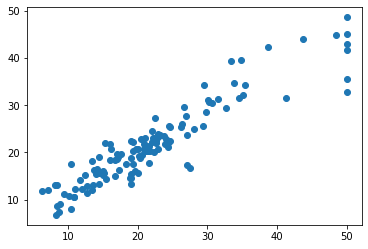

In [16]:
plt.scatter(y_test, GB.predict(x_test))

In [17]:
# boosts = []
# mses = []
# for n in [10,100,300, 500,1000]:
#   for depth in [1,2,3,4,5, 10]:
#     GBtree = CustomGB(n_estimators = n , learning_rate= 0.01 , max_depth = depth)
#     GBtree.fit(x_train, y_train)
#     boosts.append(GBtree)
#     mse = mean_squared_error(y_test, GBtree.predict(x_test))
#     mses.append(mse)
#     print("n_trees:{0}, depth:{1} ---mse: {2}".format(n, depth, mse))

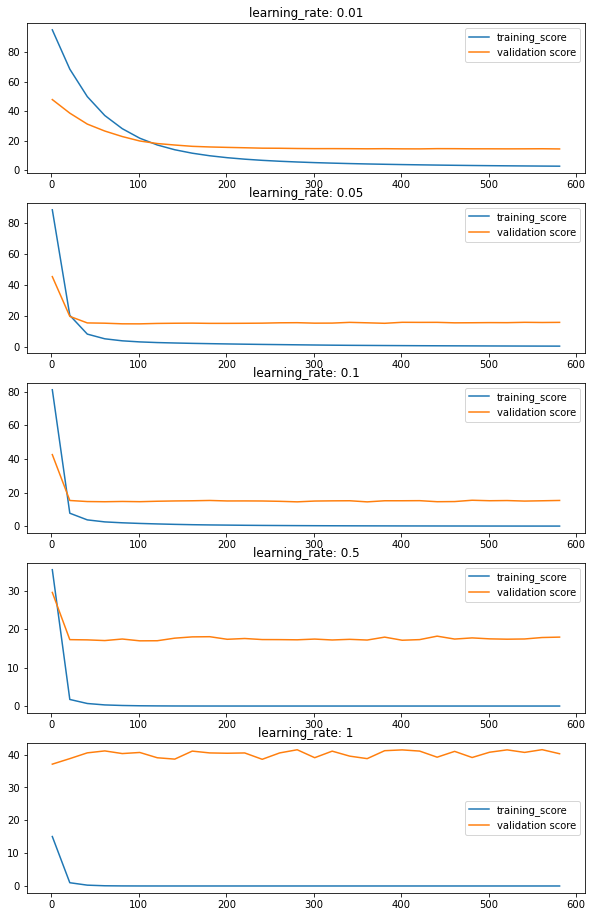

In [36]:
n_range = np.arange(start = 1, stop =600, step = 20)
learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
fig, ax = plt.subplots(len(learning_rates),1, figsize = (10,16))

for i, rate in enumerate(learning_rates):
    val_mses = []
    train_mses = []
    for n in n_range:
        # GBtree = CustomGB(n_estimators = n , learning_rate= 0.01)
        # GBtree.fit(x_train, y_train)
        GBtree = CustomGB(n_estimators = n , learning_rate= rate)
        GBtree.fit(x_train, y_train)
        train_mse = mean_squared_error(y_train, GBtree.predict(x_train) )
        val_mse = mean_squared_error(y_test, GBtree.predict(x_test))

        train_mses.append(train_mse)
        val_mses.append(val_mse)

    ax[i].plot(n_range, train_mses, label = 'training_score')
    ax[i].plot(n_range, val_mses, label = 'validation score' )  
    ax[i].set_title(f'learning_rate: {rate}')
    ax[i].legend()




### Comparing Gradient Boost to Regular Decision Tree

In [31]:
# from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()

params = {'max_depth': [None, 2, 5, 10, 20, 30, 50, 100]}
DTclf = GridSearchCV(dt, param_grid = params)
DTclf.fit(x_train, y_train)
print(DTclf.best_params_)
DT = DTclf.best_estimator_.fit(x_train, y_train)

mean_squared_error(y_test, DT.predict(x_test))


{'max_depth': 10}


25.886495493926255

In [39]:
params = {'max_depth': [None, 2, 5, 10, 20, 30, 50, 100]}
DTclf = GridSearchCV(GradientBoostingRegressor(), param_grid = params)
DTclf.fit(x_train, y_train)
print(DTclf.best_params_)
DT = DTclf.best_estimator_.fit(x_train, y_train)

mean_squared_error(y_test, DT.predict(x_test))

{'max_depth': 2}


15.473317450065636

Gradient boosting gives much better results, with a much "shorter" tree